## Data Wrangling using Spark and Data from San Francisco Police Department

The data we will be working with was made publicly available as part of the Open Data Initiative from San Francisco City.
It encompass data from police incident reports from 2018 till today. The reason this dataset was picked up in particular
was because it also contains information about location which is one of the aspects we would like to explore using the
visualisation techniques available in Python.  In particular the use of heatmaps.

[San Francisco Police Reports](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783)

For convenience the data was first downloaded and stored locally in CSV format.

At the end as I will show below it was not a very good idea to read data as CSV and I end
up using JSON which apparently has better support for types rather than delaying the type
inferrement to the CSV reader.

The LINK to the JSON API is provided: 
https://data.sfgov.org/resource/wg3w-h783.json

The API Documentation is available at the following location:
https://dev.socrata.com/foundry/data.sfgov.org/wg3w-h783

## Verify the Version of Python in use by the Spark Worker and Driver 

If running several versions of Python it is sometimes possible to have mistmatches, where the Spark Worker is using a different version of Python than the Spark Driver. This error can be hard to debug, because it usually manifests only after performing data transformations, where a client defined mapping is executed by the worker process. 

### Example of Java Stack Trace Thrown due to Python Mismatch

Py4JJavaError: An error occurred while calling o143.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 28.0 failed 1 times, most recent failure: Lost task 0.0 in stage 28.0 (TID 31, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 267, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.5, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

To properly configure the python version used by Spark, you can use this guide: [Learn PySpark Installation Tutorial](https://www.kdnuggets.com/2019/08/learn-pyspark-installation-tutorial.html)

## Removing any Existing Spark Session

This is used to force any existing spark session to close, starting with a clean slate.

In [1]:
try:
    session.stop()
except:
    pass

## Creating a Spark Session

First we need to import Spark and some useful spark objects in order to use Spark. In particular we need to create the Spark Session. Previous versions of Spark relied on three different classes, among them the SparkContext, but in later versions of Spark, the use has been simplified and most of the complicated stuff is largely abstracted by the Spark Dataframe and Spark SQL APIs.

In [2]:
# As its name implies this module is used to find the spark home directory
#import findspark
#findspark.init()

ImportError: No module named 'findspark'

Proceed to create the session and configure some necessary JVM parameters like the amount of memory used by the spark driver and the number of cores used for parallel processing of spark tasks. 

In [2]:
import pyspark

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

number_cores = 4
memory_gb = 4
conf = (
    pyspark.SparkConf()
        .setMaster('local[{}]'.format(number_cores))
        .set('spark.driver.memory', '{}g'.format(memory_gb))
)

builder = SparkSession.builder\
    .master('local[{}]'.format(number_cores))\
    .appName('mapping-crime-in-san-francisco')

builder.config('spark.driver.memory', '{}g'.format(memory_gb))
    
session = builder.getOrCreate()

Displaying session parameters. If session creation step above did not succeed an error will be triggered at this point.

In [3]:
session.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1573179283302'),
 ('spark.master', 'local[4]'),
 ('spark.driver.memory', '4g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '34553'),
 ('spark.driver.host', '192.168.1.181'),
 ('spark.app.name', 'mapping-crime-in-san-francisco'),
 ('spark.ui.showConsoleProgress', 'true')]

Now we are ready to read the data.  First we were reading CSV, but the JSON prove to be more convenient. Notice that in the Open Data website is also possible to download the data in a 
format called GeoJSON which is a superset of JSON. Is important not to confuse them both. 

I taught otherwise and I end up stuck with a format that altought being parsed by the JSON reader is largely incompatible with the rest of Spark data manipulation model. 

If you are curious about the differences between JSON and Geo JSON I would reccommend you the following resuource. It's from there that I learned GeoJSON is a superset of JSON.
[JSON vs GeoJSON](https://github.com/earthcubeprojects-chords/chords/wiki/JSON-vs-GeoJSON)

## Familiarizing with the Data

As a first step to get familiar with the data we print the schema to see which fields are there.

In [5]:
data_path = "data/Police_Department_Incident_Reports_2018_to_Present.csv"
crime_reports = session.read.csv(data_path)

crime_reports.printSchema()
crime_reports.count()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

278807

## Reading Crime Incident Data Encoded in JSON

The Open Data Website also provide the option to download the data using a very nice API, that supports several different output formats,  among them it supports JSON which is a human readable data transfer format commonly used by JavaScript REST platforms.

https://dev.socrata.com/foundry/data.sfgov.org/wg3w-h783

In [6]:
data_path_json = "data/wg3w-h783.json"
crime_reports_json = session.read.json(data_path_json)

crime_reports_json.printSchema()

root
 |-- _corrupt_record: string (nullable = true)



Hmm.. So what happened?  Well I learned once again that although this format is mostly JSON, it is not strict JSON but JSONL.  A format created as a replacement to CSV.  If interested about the difference I included a reference below.

https://stackoverflow.com/questions/38895057/reading-json-with-apache-spark-corrupt-record

What we need instead is to provide the JSON reader with a file where every single line is a proper JSON object. 

Let's begin by loading a JSON file, where each line is a JSON object:

In [7]:
crime_reports_jsonl = session.read.option("multiline", "true").json(data_path_json)

In [8]:
crime_reports_jsonl.printSchema()

root
 |-- :@computed_region_26cr_cadq: string (nullable = true)
 |-- :@computed_region_2dwj_jsy4: string (nullable = true)
 |-- :@computed_region_6qbp_sg9q: string (nullable = true)
 |-- :@computed_region_ajp5_b2md: string (nullable = true)
 |-- :@computed_region_h4ep_8xdi: string (nullable = true)
 |-- :@computed_region_jg9y_a9du: string (nullable = true)
 |-- :@computed_region_nqbw_i6c3: string (nullable = true)
 |-- :@computed_region_qgnn_b9vv: string (nullable = true)
 |-- :@computed_region_y6ts_4iup: string (nullable = true)
 |-- analysis_neighborhood: string (nullable = true)
 |-- cad_number: string (nullable = true)
 |-- cnn: string (nullable = true)
 |-- filed_online: boolean (nullable = true)
 |-- incident_category: string (nullable = true)
 |-- incident_code: string (nullable = true)
 |-- incident_date: string (nullable = true)
 |-- incident_datetime: string (nullable = true)
 |-- incident_day_of_week: string (nullable = true)
 |-- incident_description: string (nullable = tru

In [9]:
crime_reports_jsonl.describe()

DataFrame[summary: string, :@computed_region_26cr_cadq: string, :@computed_region_2dwj_jsy4: string, :@computed_region_6qbp_sg9q: string, :@computed_region_ajp5_b2md: string, :@computed_region_h4ep_8xdi: string, :@computed_region_jg9y_a9du: string, :@computed_region_nqbw_i6c3: string, :@computed_region_qgnn_b9vv: string, :@computed_region_y6ts_4iup: string, analysis_neighborhood: string, cad_number: string, cnn: string, incident_category: string, incident_code: string, incident_date: string, incident_datetime: string, incident_day_of_week: string, incident_description: string, incident_id: string, incident_number: string, incident_subcategory: string, incident_time: string, incident_year: string, intersection: string, latitude: string, longitude: string, police_district: string, report_datetime: string, report_type_code: string, report_type_description: string, resolution: string, row_id: string, supervisor_district: string]

In [10]:
crime_reports_jsonl.take(2)

[Row(:@computed_region_26cr_cadq=None, :@computed_region_2dwj_jsy4=None, :@computed_region_6qbp_sg9q=None, :@computed_region_ajp5_b2md=None, :@computed_region_h4ep_8xdi=None, :@computed_region_jg9y_a9du=None, :@computed_region_nqbw_i6c3=None, :@computed_region_qgnn_b9vv=None, :@computed_region_y6ts_4iup=None, analysis_neighborhood=None, cad_number=None, cnn=None, filed_online=True, incident_category='Larceny Theft', incident_code='06374', incident_date='2019-08-15T00:00:00.000', incident_datetime='2019-08-15T11:41:00.000', incident_day_of_week='Thursday', incident_description='Theft, Other Property, >$950', incident_id='854240', incident_number='196208089', incident_subcategory='Larceny Theft - Other', incident_time='11:41', incident_year='2019', intersection=None, latitude=None, longitude=None, point=None, police_district='Central', report_datetime='2019-10-01T14:06:00.000', report_type_code='II', report_type_description='Coplogic Initial', resolution='Open or Active', row_id='8542400

In [11]:
crime_reports_jsonl.count()

1000

In [12]:
crime_reports_jsonl.describe("resolution", "incident_category").show()

+-------+--------------+-----------------+
|summary|    resolution|incident_category|
+-------+--------------+-----------------+
|  count|          1000|             1000|
|   mean|          null|             null|
| stddev|          null|             null|
|    min|Open or Active|            Arson|
|    max|     Unfounded|  Weapons Offense|
+-------+--------------+-----------------+



In [13]:
crime_reports_jsonl.describe("incident_year", "incident_time").show()

+-------+------------------+-------------+
|summary|     incident_year|incident_time|
+-------+------------------+-------------+
|  count|              1000|         1000|
|   mean|          2018.985|         null|
| stddev|0.1216132796605237|         null|
|    min|              2018|        00:00|
|    max|              2019|        23:45|
+-------+------------------+-------------+



## Selecting a Subset of the Data for Processing

In this dataset there are some fields are more interesting for me to analyze than others. Also in order to enhace and reduce the amount of data being processed it is advised to create a dataframe from just the data we would like to process.

In [14]:
incidents = crime_reports_jsonl.select(["resolution","incident_category", "incident_time"])

In [15]:
# Displaying rows in JSON list format
incidents.take(5)

[Row(resolution='Open or Active', incident_category='Larceny Theft', incident_time='11:41'),
 Row(resolution='Open or Active', incident_category='Larceny Theft', incident_time='22:00'),
 Row(resolution='Open or Active', incident_category='Robbery', incident_time='14:25'),
 Row(resolution='Open or Active', incident_category='Larceny Theft', incident_time='19:30'),
 Row(resolution='Open or Active', incident_category='Non-Criminal', incident_time='16:53')]

In [16]:
# Displaying incidents in tabular format
incidents.show(n=5)

+--------------+-----------------+-------------+
|    resolution|incident_category|incident_time|
+--------------+-----------------+-------------+
|Open or Active|    Larceny Theft|        11:41|
|Open or Active|    Larceny Theft|        22:00|
|Open or Active|          Robbery|        14:25|
|Open or Active|    Larceny Theft|        19:30|
|Open or Active|     Non-Criminal|        16:53|
+--------------+-----------------+-------------+
only showing top 5 rows



## Calculating Crime Statistics by Hour of the Day

A first simple visualization task would be to generate crime statistics depending on the time of the day.  Sort of finding out what time of the day is associated with more criminal activity.   I choosed this task because I tought it could be something useful to know as well as give me more opportunity to familiarize with the processing of data in Spark. In particular the use of lambda functions to produce data mappings and filtering results.

First start by defining a function to extract the hour of the day from the incident_time field

In [17]:
import datetime
from pyspark.sql.functions import udf

get_hour = udf(lambda x: datetime.datetime.strptime(x, '%H:%M'). hour)

In [18]:
incidents.head()

Row(resolution='Open or Active', incident_category='Larceny Theft', incident_time='11:41')

The spark dataframe supports two functions with equivalent functionality: filter and where
To exemplify their use we first use one to find those incidents where time is null or equivalently find the total number of rows having non-null incident time values.

In [19]:
# Using filter with spark dataframe and spark sql syntax
incidents.filter("incident_time is null").count()

0

In [20]:
# Using where with spar dataframe and spark sql syntax
incidents.where("incident_time is not null").count()

1000

In [21]:
incidents = incidents.withColumn("hour", get_hour(incidents.incident_time))
incidents.head()

Row(resolution='Open or Active', incident_category='Larceny Theft', incident_time='11:41', hour='11')

## Grouping Incidents By Hour of the Day

The following example is used to illustrate the use of Spark Dataframe to group and order results using a particular column from the dataframe

In [23]:
incidents_in_hour = incidents.groupby(incidents.hour).count().orderBy(incidents.hour.cast("float"))
incidents_in_hour.show(n=24)

+----+-----+
|hour|count|
+----+-----+
|   0|   54|
|   1|   38|
|   2|   23|
|   3|    7|
|   4|   10|
|   5|   20|
|   6|   15|
|   7|   17|
|   8|   29|
|   9|   38|
|  10|   41|
|  11|   53|
|  12|   56|
|  13|   46|
|  14|   60|
|  15|   61|
|  16|   42|
|  17|   58|
|  18|   90|
|  19|   66|
|  20|   63|
|  21|   41|
|  22|   42|
|  23|   30|
+----+-----+



## Converting between Spark Dataframe and Pandas Dataframe

Sometimes for visualization purposes is necessary to convert between Spark Dataframe and Pandas Dataframe.

In [24]:
import pandas as pd

incidents_in_hour_pd = incidents_in_hour.toPandas()
incidents_in_hour_pd.hour = pd.to_numeric(incidents_in_hour_pd.hour)

## Plotting San Francisco Police Crime Incidents using Matplotlib

Text(0, 0.5, 'Incidents Reported')

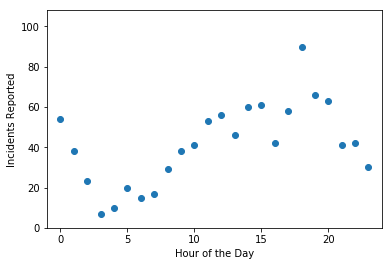

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(incidents_in_hour_pd["hour"], incidents_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(incidents_in_hour_pd["count"]))
plt.xlabel("Hour of the Day")
plt.ylabel("Incidents Reported")

### This essentially can be used to disprove the saying: "The Crime Never Sleeps"  💤 💤 💤

FUN FACT: Jupyter Notebook also supports the use of Emojis. Either encoded or simply copy paste them from  [EMOJIPEDIA](https://emojipedia.org/) 😄

## PROPERLY READING CSV FILE

At some point reading the API I realized the way I was reading the CSV file was incorrect.  The proper way to do it is to pass an optional parameter to indicate the spark to use the CSV header as follows:

In [29]:
data_path = "data/Police_Department_Incident_Reports_2018_to_Present.csv"
crime_reports = session.read.csv(data_path, header=True)

crime_reports.printSchema()
crime_reports.count()

root
 |-- Incident Datetime: string (nullable = true)
 |-- Incident Date: string (nullable = true)
 |-- Incident Time: string (nullable = true)
 |-- Incident Year: string (nullable = true)
 |-- Incident Day of Week: string (nullable = true)
 |-- Report Datetime: string (nullable = true)
 |-- Row ID: string (nullable = true)
 |-- Incident ID: string (nullable = true)
 |-- Incident Number: string (nullable = true)
 |-- CAD Number: string (nullable = true)
 |-- Report Type Code: string (nullable = true)
 |-- Report Type Description: string (nullable = true)
 |-- Filed Online: string (nullable = true)
 |-- Incident Code: string (nullable = true)
 |-- Incident Category: string (nullable = true)
 |-- Incident Subcategory: string (nullable = true)
 |-- Incident Description: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Intersection: string (nullable = true)
 |-- CNN: string (nullable = true)
 |-- Police District: string (nullable = true)
 |-- Analysis Neighborhood: s

278806

## Removing spaces in Column Headers

The Column Headers contain spaces which are cumbersome to process when writing queries operating on them. Therefore we remove the spaces from column titles using a bit of Python magic.

In [40]:
incidents = crime_reports
for col in crime_reports.columns:
    incidents = incidents.withColumnRenamed(col,col.replace(" ", "_"))    

incidents.printSchema()

root
 |-- Incident_Datetime: string (nullable = true)
 |-- Incident_Date: string (nullable = true)
 |-- Incident_Time: string (nullable = true)
 |-- Incident_Year: string (nullable = true)
 |-- Incident_Day_of_Week: string (nullable = true)
 |-- Report_Datetime: string (nullable = true)
 |-- Row_ID: string (nullable = true)
 |-- Incident_ID: string (nullable = true)
 |-- Incident_Number: string (nullable = true)
 |-- CAD_Number: string (nullable = true)
 |-- Report_Type_Code: string (nullable = true)
 |-- Report_Type_Description: string (nullable = true)
 |-- Filed_Online: string (nullable = true)
 |-- Incident_Code: string (nullable = true)
 |-- Incident_Category: string (nullable = true)
 |-- Incident_Subcategory: string (nullable = true)
 |-- Incident_Description: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Intersection: string (nullable = true)
 |-- CNN: string (nullable = true)
 |-- Police_District: string (nullable = true)
 |-- Analysis_Neighborhood: s

## Word Cloud Visualization

A word cloud is one fancy visualization that use word sizes to represent common topics in our data. I tought it would be interesting to generate a Word Cloud for our dataset. In particualr I was interested in Incident Descriptions and Incident Resolution.  

### Using Spark SQL and Temporary Tables

The Spark SQL API is particularly useful to perform complex queries and join tables from different datasources. The first step involves registering the dataframe as a temporary table.

In [42]:
incidents.registerTempTable("incidents")

Lets try now one simple query to recover the counts of resolutions inside the incidents table.

In [43]:
resolutions = session.sql(
  """SELECT Resolution, COUNT(*) AS Count
     FROM incidents
     GROUP BY Resolution""")

resolutions.show()

+--------------------+------+
|          Resolution| Count|
+--------------------+------+
|Exceptional Juvenile|    88|
|      Cite or Arrest| 64993|
|           Unfounded|  2010|
|      Open or Active|210988|
|   Exceptional Adult|   727|
+--------------------+------+



And now from some extra level of complexity we want the incidents more often reporte for each neighborhood.

In [59]:
max_categories_by_neighborhood = session.sql(
    """SELECT Analysis_Neighborhood, 
              Incident_Category, 
              COUNT(Incident_Category) as Total_Incidents
       FROM incidents
       WHERE Analysis_Neighborhood != 'null'
       GROUP BY Analysis_Neighborhood, Incident_Category
       HAVING COUNT(Incident_Category) > 1000
       ORDER BY Analysis_Neighborhood ASC, Total_Incidents DESC
    """)

max_categories_by_neighborhood.show(n=30)

+---------------------+-------------------+---------------+
|Analysis_Neighborhood|  Incident_Category|Total_Incidents|
+---------------------+-------------------+---------------+
| Bayview Hunters P...|      Larceny Theft|           2436|
| Bayview Hunters P...|            Assault|           1468|
| Bayview Hunters P...|Other Miscellaneous|           1275|
| Bayview Hunters P...| Malicious Mischief|           1154|
| Bayview Hunters P...|Motor Vehicle Theft|           1113|
|       Bernal Heights|      Larceny Theft|           1084|
|  Castro/Upper Market|      Larceny Theft|           2404|
|            Chinatown|      Larceny Theft|           1605|
| Financial Distric...|      Larceny Theft|          10222|
| Financial Distric...|Other Miscellaneous|           2115|
| Financial Distric...|           Burglary|           1475|
| Financial Distric...| Malicious Mischief|           1404|
| Financial Distric...|            Assault|           1397|
| Financial Distric...|      Lost Proper

### Visuailizing Crime Offences using Word Clouds

Last we would like to build a Word Cloud using the Descriptions from Incident Reports

In [75]:
descriptions = session.sql(
  """SELECT Incident_Description AS Description
     FROM incidents""")

descriptions.show(n=3)

+--------------------+
|         Description|
+--------------------+
|Theft, Other Prop...|
|Theft, Other Prop...|
|Robbery, Att., W/...|
+--------------------+
only showing top 3 rows



['Theft, Other Property, >$950', 'Theft, Other Property, >$950', 'Robbery, Att., W/ Force']


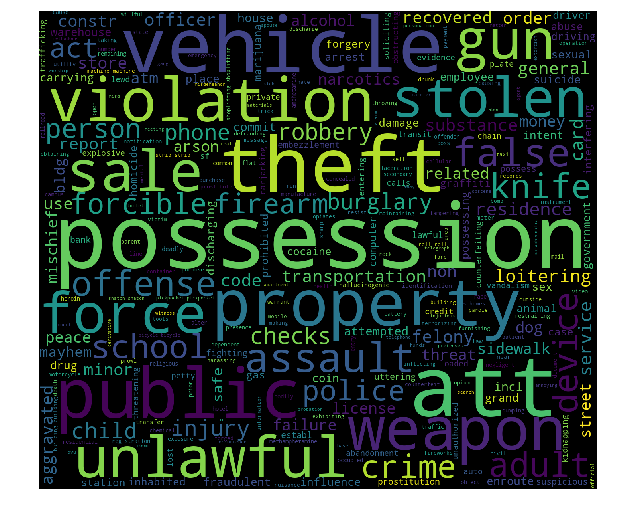

In [83]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

descriptions_pd = descriptions.toPandas()
descriptions_list = descriptions_pd['Description'].values.tolist()

print(descriptions_list[0:3])

vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=.5)
tfv = vec.fit_transform(descriptions_list)

terms = vec.get_feature_names()
wc = WordCloud(height=1200, width=1400, max_words=300).generate(" ".join(terms))

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()